##### 🦍 TinyDeepseek-MoE (26M-A12M)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
import tiktoken
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from dataclasses import dataclass

In [2]:
@dataclass
class ModelConfig:
    vocab_size: int = 50304
    embd_dim: int = 256
    num_head: int = 8
    latent_dim: int = 64
    rope_dim: int = 32
    d_ff: int = 512
    num_experts: int = 8
    top_k: int = 2
    load_balance_alpha: float = 0.01
    capacity_factor: float = 1.25
    bias_update_speed: float = 0.1
    load_tracking_momentum: float = 0.1
    num_layers: int = 4
    dropout: float = 0.1


In [3]:
class MLA(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.num_head = config.num_head
        self.embd_dim = config.embd_dim
        self.head_dim = config.embd_dim // config.num_head
        self.rope_dim = min(config.rope_dim, self.head_dim)
        self.rope_half = self.rope_dim // 2
        self.scale = self.head_dim ** -0.5
        self.compress_kv = nn.Linear(config.embd_dim, config.latent_dim, bias=False)
        self.kv_proj = nn.Linear(config.latent_dim, 2 * config.embd_dim, bias=False)
        self.compress_q = nn.Linear(config.embd_dim, config.latent_dim, bias=False)
        self.q_proj = nn.Linear(config.latent_dim, config.embd_dim, bias=False)
        self.q_rope = nn.Linear(config.latent_dim, config.num_head * self.rope_dim, bias=False)
        self.k_rope = nn.Linear(config.latent_dim, self.rope_dim, bias=False)

        # Output projection + dropout
        self.out_proj = nn.Linear(config.embd_dim, config.embd_dim, bias=False)
        self.attn_dropout = nn.Dropout(config.dropout)
        self._init_rope()

    def _init_rope(self):
        inv_freq = 1.0 / (10000.0 ** (torch.arange(0, self.rope_dim, 2, dtype=torch.float32) / self.rope_dim))
        self.register_buffer('inv_freq', inv_freq, persistent=False)
        self._cos_cache = {}
        self._sin_cache = {}

    def forward(self, x):
        B, S, _ = x.shape
        c_kv = self.compress_kv(x)
        kv = self.kv_proj(c_kv)
        c_q = self.compress_q(x)
        q_c = self.q_proj(c_q)

        # RoPE inputs
        q_r = self.q_rope(c_q).view(B, S, self.num_head, self.rope_dim).transpose(1, 2)
        k_r = self.k_rope(c_kv).unsqueeze(1).expand(-1, self.num_head, -1, -1)

        # Content projections
        q_c = q_c.view(B, S, self.num_head, self.head_dim).transpose(1, 2)
        k_c, v = kv.chunk(2, dim=-1)
        k_c = k_c.view(B, S, self.num_head, self.head_dim).transpose(1, 2)
        v = v.view(B, S, self.num_head, self.head_dim).transpose(1, 2)

        # Apply RoPE
        q_r = self._apply_rope(q_r, S)
        k_r = self._apply_rope(k_r, S)

        # Combine
        q = torch.cat([q_c, q_r], dim=-1)
        k = torch.cat([k_c, k_r], dim=-1)
        attended = F.scaled_dot_product_attention(q, k, v, is_causal=True, scale=self.scale)
        out = attended.transpose(1, 2).contiguous().view(B, S, self.embd_dim)

        # Project and dropout
        out = self.out_proj(out)
        return self.attn_dropout(out)
    
    def _get_rope_cache(self, S, device):
        if S in self._cos_cache:
            return self._cos_cache[S], self._sin_cache[S]
        pos = torch.arange(S, dtype=torch.float32, device=device)
        freqs = torch.outer(pos, self.inv_freq)
        cos_vals = torch.cos(freqs).view(1, 1, S, self.rope_half)
        sin_vals = torch.sin(freqs).view(1, 1, S, self.rope_half)
        self._cos_cache[S], self._sin_cache[S] = cos_vals, sin_vals
        return cos_vals, sin_vals
    
    def _apply_rope(self, x, S):
        cos_vals, sin_vals = self._get_rope_cache(S, x.device)
        x_even, x_odd = x[..., 0::2], x[..., 1::2]
        x_rot = torch.empty_like(x[..., :self.rope_dim])
        x_rot[..., 0::2] = x_even * cos_vals - x_odd * sin_vals
        x_rot[..., 1::2] = x_even * sin_vals + x_odd * cos_vals
        return x_rot

In [27]:

class FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.gate_proj = nn.Linear(config.embd_dim, config.d_ff, bias=False)
        self.up_proj   = nn.Linear(config.embd_dim, config.d_ff, bias=False)
        self.down_proj = nn.Linear(config.d_ff, config.embd_dim, bias=False)
        self.ffn_dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = self.down_proj(F.silu(self.gate_proj(x)) * self.up_proj(x))
        return self.ffn_dropout(out)
    
class MOELayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_experts = config.num_experts
        self.top_k = config.top_k
        self.bias_update_speed     = config.bias_update_speed
        self.load_tracking_momentum = config.load_tracking_momentum
        self.experts      = nn.ModuleList([FFN(config) for _ in range(self.num_experts)])
        self.centroids    = nn.Parameter(torch.randn(self.num_experts, config.embd_dim))
        self.routing_bias = nn.Parameter(torch.zeros(self.num_experts), requires_grad=False)
        self.register_buffer("expert_load_ema", torch.zeros(self.num_experts))

    def forward(self, x):
        B, S, H = x.shape
        x_flat = x.view(-1, H)
        affinity = torch.sigmoid(x_flat @ self.centroids.T)
        biased = affinity + self.routing_bias
        topk_scores, topk_idx = torch.topk(biased, self.top_k, dim=-1)
        topk_w = F.softmax(topk_scores, dim=-1)
        token_idx   = torch.arange(x_flat.size(0), device=x.device).repeat_interleave(self.top_k)
        flat_idx    = topk_idx.flatten()
        flat_w      = topk_w.flatten()
        order       = torch.argsort(flat_idx)
        perm_tokens = x_flat[token_idx[order]]
        perm_w      = flat_w[order]
        counts = torch.bincount(flat_idx, minlength=self.num_experts)
        starts = torch.cumsum(counts, dim=0) - counts
        expert_outs = torch.empty_like(perm_tokens)

        for i in range(self.num_experts):
            c = counts[i].item()
            if c > 0:
                s = starts[i]
                expert_outs[s:s+c] = self.experts[i](perm_tokens[s:s+c])

        weighted = expert_outs * perm_w.unsqueeze(1)
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_add_(0, token_idx[order].unsqueeze(1).expand_as(weighted), weighted)
        return out_flat.view(B, S, H), counts.detach()
    
# Bias update 
def update_moe_bias(moe_layer: MOELayer, expert_counts: torch.Tensor):
    total = expert_counts.sum().item()
    if total == 0:
        return
    load = expert_counts.float() / total
    expected = 1.0 / moe_layer.num_experts
    moe_layer.expert_load_ema.mul_(1 - moe_layer.load_tracking_momentum)
    moe_layer.expert_load_ema.add_(moe_layer.load_tracking_momentum * load)
    delta = moe_layer.bias_update_speed * (expected - moe_layer.expert_load_ema)
    moe_layer.routing_bias.add_(delta)


In [28]:

class DeepseekBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1  = nn.LayerNorm(config.embd_dim)
        self.attn = MLA(config)
        self.ln2  = nn.LayerNorm(config.embd_dim)
        self.ffn  = MOELayer(config)
        
    def forward(self, x):
        attn_out = self.attn(self.ln1(x))
        x = x + attn_out
        ffn_out, counts = self.ffn(self.ln2(x))
        x = x + ffn_out
        return x, counts

In [29]:

class DeepseekModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.token_embd = nn.Embedding(config.vocab_size, config.embd_dim)
        self.token_dropout = nn.Dropout(config.dropout)
        self.blocks     = nn.ModuleList([DeepseekBlock(config) for _ in range(config.num_layers)])
        self.ln_final   = nn.LayerNorm(config.embd_dim)
        self.head       = nn.Linear(config.embd_dim, config.vocab_size, bias=False)
        self.head.weight = self.token_embd.weight
        self.apply(self._init_weights)

    def _init_weights(self,m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
                
    def forward(self, input_ids):
        x = self.token_dropout(self.token_embd(input_ids))
        all_counts = []
        for block in self.blocks:
            x, counts = block(x)
            all_counts.append(counts)
        x = self.ln_final(x)
        return self.head(x), all_counts

In [30]:
config = ModelConfig()
model = DeepseekModel(config)
total_parameters = sum(p.numel() for p in model.parameters())
print(f"{total_parameters / 1e6:.2f}M")

26.14M


In [31]:
model.eval()

DeepseekModel(
  (token_embd): Embedding(50304, 256)
  (token_dropout): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x DeepseekBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MLA(
        (compress_kv): Linear(in_features=256, out_features=64, bias=False)
        (kv_proj): Linear(in_features=64, out_features=512, bias=False)
        (compress_q): Linear(in_features=256, out_features=64, bias=False)
        (q_proj): Linear(in_features=64, out_features=256, bias=False)
        (q_rope): Linear(in_features=64, out_features=256, bias=False)
        (k_rope): Linear(in_features=64, out_features=32, bias=False)
        (out_proj): Linear(in_features=256, out_features=256, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): MOELayer(
        (experts): ModuleList(
          (0-7): 8 x FFN(
            (gate_proj): Linear(in_featu

In [32]:
model.load_state_dict(torch.load('weights.pth', map_location=device))

<All keys matched successfully>

In [33]:
enc = tiktoken.encoding_for_model('gpt2')

In [ ]:
# some results

"""
Sample 1: love, I was taught from the Bible,  
And he gave me strength to bring, my joy,  
But my soul said ""hey""  
I never meant, no no, no no no no, no no no no!""  
  
Yeah, I went down to the shore,  
Just to turn the page, but I couldn't handle all the other fools,  
I'm a man who walked around like Moses, said, ""Let me go""  
We got drunk on the shore,  
Just to turn the page,  
If my heart said you would stay,  
You'd run for nothing but fear,  
Cause, I found a love I was taught to give,  
But, my heart said ""hello""  
  
No, I'd never do, no way, no no no no  
No, I'd cry for nothing but fear,  
Well, I took some time to look the other lovers that you put in my heart.  
And they took me for nothing but fear,  
But my soul said ""hello"" to the moon, who was made for the sea,  
I had time to give, who I was taught from the Bible,  
He broke my heart and ran through my life, it's all  
  
No, I'd never do, no no no no no, no no no no no no no no no no no no no no no one ever wanted me to make the grade, 
But my soul said ""hello"" to the moon went wild (hello)              
But my tongue said ""hello"" to the truth to the sea                                  
Nobody came and

"""

In [35]:
prompt = torch.tensor(enc.encode("love"), dtype=torch.long).unsqueeze(0).to(device)
xgen = prompt.repeat(3, 1)
while xgen.size(1) <  128:
    with torch.no_grad():
        logits, _ = model(xgen)
        next_logits = logits[:, -1, :]
        probs = F.softmax(next_logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 80, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        next_token = torch.gather(topk_indices, -1, ix)
        xgen = torch.cat((xgen, next_token), dim=1)
for i in range(3):  
    print(f"sample {i}: {enc.decode(xgen[i].tolist())}")

sample 0: love a man is my song  
Carry the crown I need  
Come on and say goodbye  
  
Well oh you know, you got the feelin'  
In this corner of your eye  
I'm the one who is my songs  
In this corner of your eye

"
"I saw your shadow of the stars  
I saw your shadow of an empty cage  
He looked into your eyes  
Well then you thought that I was your man  
Well now there's more I've felt you hold  

sample 1: love  
One eye that takes you away  
  
Farewell...  
  
I want a girl for you baby  
One eye that takes you away  
  
How can you see, you're a woman  
You say, you're a woman, you know you can  
You're a woman me, you know you can  
You better believe  
Do what you see, you're a woman  
You can have my life and I can give it all again  
(I want love you) I
sample 2: love with all my heart  
Whoa  
I wanted, now I'm crying  
But nothing else is telling me  
I'm in L.A.  
(Do do do do do do)  
I got so much patience  
Ooooo  
  
Love it up my mind  
Love it up my mind  
You make m

In [18]:
prompt = torch.tensor(enc.encode("love"), dtype=torch.long).unsqueeze(0).to(device)
xgen = prompt.repeat(3, 1)
while xgen.size(1) <  128:
    with torch.no_grad():
        logits, _ = model(xgen)
        next_logits = logits[:, -1, :]
        probs = F.softmax(next_logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        next_token = torch.gather(topk_indices, -1, ix)
        xgen = torch.cat((xgen, next_token), dim=1)
for i in range(3):  # Changed from 5 to 3
    print(f"sample {i}: {enc.decode(xgen[i].tolist())}")

sample 0: love's a love song  
Come on baby, let it be  
We're up to Diddle  
Oh, let it be  
  
Oh baby, we're up  
  
Give it up, put it on  
Give it up, put it on  
And give it up, put it on  
Give it up, put it on  
Give it up, put it on  
  
There ain't no place like this  
Like a shadow  
And there ain't no place to go
sample 1: love? Well?  
You really got no sense  
You really got no sense  
You want such an image - I just like you  
I got my own identity  
  
In my own condition -  
Oh  
Oh  
  
You're not a one... But I mean,  
You've got no sense  
You want much to see  
  
You got to be out tonight  
I just am a one  
I got my own identity  
  
But it
sample 2: love to the love  
  
When I'm with you  
When I'm with you  
  
Love to the love  
I'm holding on, there's no time for love  
What we're talking about  
Love to the love

"
"When the wind blows  
I am going so crazy  
I can see a baby cry  
Is it me or you  
  
You can't break me down  
I don't feel it  
I don't fee

In [ ]:
# holly molly -> it’s learning hooks, repetition, mood, emotional stance, and even linguistic rhythm 🦍.

In [23]:
prompt = torch.tensor(enc.encode(f"heartbreak"), dtype=torch.long).unsqueeze(0).to(device)
xgen = prompt.repeat(2, 1)
while xgen.size(1) <  128:
    with torch.no_grad():
        logits, _ = model(xgen)
        next_logits = logits[:, -1, :]
        probs = F.softmax(next_logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        next_token = torch.gather(topk_indices, -1, ix)
        xgen = torch.cat((xgen, next_token), dim=1)
for i in range(2): 
    print(f"sample {i}: {enc.decode(xgen[i].tolist())}")

sample 0: heartbreak  
And when I open the door I see  
  
A woman's heartache  
She's broken blue  
She's broken blue  
  
But she didn't think she'd die  
I never think she'd die  
She tried to hold her heart  
But she couldn't do that long and lonely day  
  
A woman's heartache  
She's broken blue  
Taken blue  
  
A woman's heartache  
She's broken blue  

sample 1: heartbreak for sure you've got a hold on me  
  
You ain't got a grip  
I got something to say  
I got 'em on my mind  
  
Don't stop this feeling, don't stop this feeling, don't stop this feeling, don't stop this feeling)  
Cause I've got the heartache for sure you've got a hold on me  
  
Please be my lover  
Please be my lover  
Please be my lover  
  
My lover  
Your lover 


In [36]:
def analyze_expert_usage(model, input_ids, generation_length=128):
    model.eval()
    all_expert_counts = []
    active_params_per_token = []
    with torch.no_grad():
        xgen = input_ids.clone()
        while xgen.size(1) < generation_length:
            logits, counts = model(xgen)
            all_expert_counts.append([c.cpu().numpy() for c in counts])
            params_per_token = count_active_parameters(model, counts)
            active_params_per_token.append(params_per_token)
            next_logits = logits[:, -1, :]
            probs = F.softmax(next_logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs, 1)
            next_token = torch.gather(topk_indices, -1, ix)
            xgen = torch.cat((xgen, next_token), dim=1)
    return xgen, all_expert_counts, active_params_per_token
def count_active_parameters(model,counts):
    ffn_params_per_expert = sum(p.numel() for p in model.blocks[0].ffn.experts[0].parameters())
    active_params = 0
    for layer_idx, layer_counts in enumerate(counts):
        active_params += sum(p.numel() for name, p in model.named_parameters() 
               if f'blocks.{layer_idx}' in name and 'ffn.experts' not in name)
        for expert_idx, count in enumerate(layer_counts):
            if count > 0:
                active_params += ffn_params_per_expert
    return active_params

In [37]:
def visualize_expert_usage(all_expert_counts):
    import matplotlib.pyplot as plt
    import numpy as np
    layer_counts = [np.zeros(config.num_experts) for _ in range(config.num_layers)]
    for step_counts in all_expert_counts:
        for layer_idx, expert_counts in enumerate(step_counts):
            layer_counts[layer_idx] += expert_counts
    layer_percentages = [counts / counts.sum() * 100 for counts in layer_counts]
    fig, axes = plt.subplots(config.num_layers, 1, figsize=(10, 3*config.num_layers))
    for layer_idx, percentages in enumerate(layer_percentages):
        ax = axes[layer_idx] if config.num_layers > 1 else axes
        ax.bar(range(config.num_experts), percentages)
        ax.set_title(f'Layer {layer_idx} Expert Usage')
        ax.set_xlabel('Expert ID')
        ax.set_ylabel('Usage %')
        ax.set_xticks(range(config.num_experts))
    plt.tight_layout()
    plt.show()
    print("\nExpert Usage Summary:")
    for layer_idx, percentages in enumerate(layer_percentages):
        print(f"Layer {layer_idx}:", end=" ")
        for expert_idx, pct in enumerate(percentages):
            print(f"E{expert_idx}: {pct:.1f}%", end="  ")
        print()
    return layer_percentages

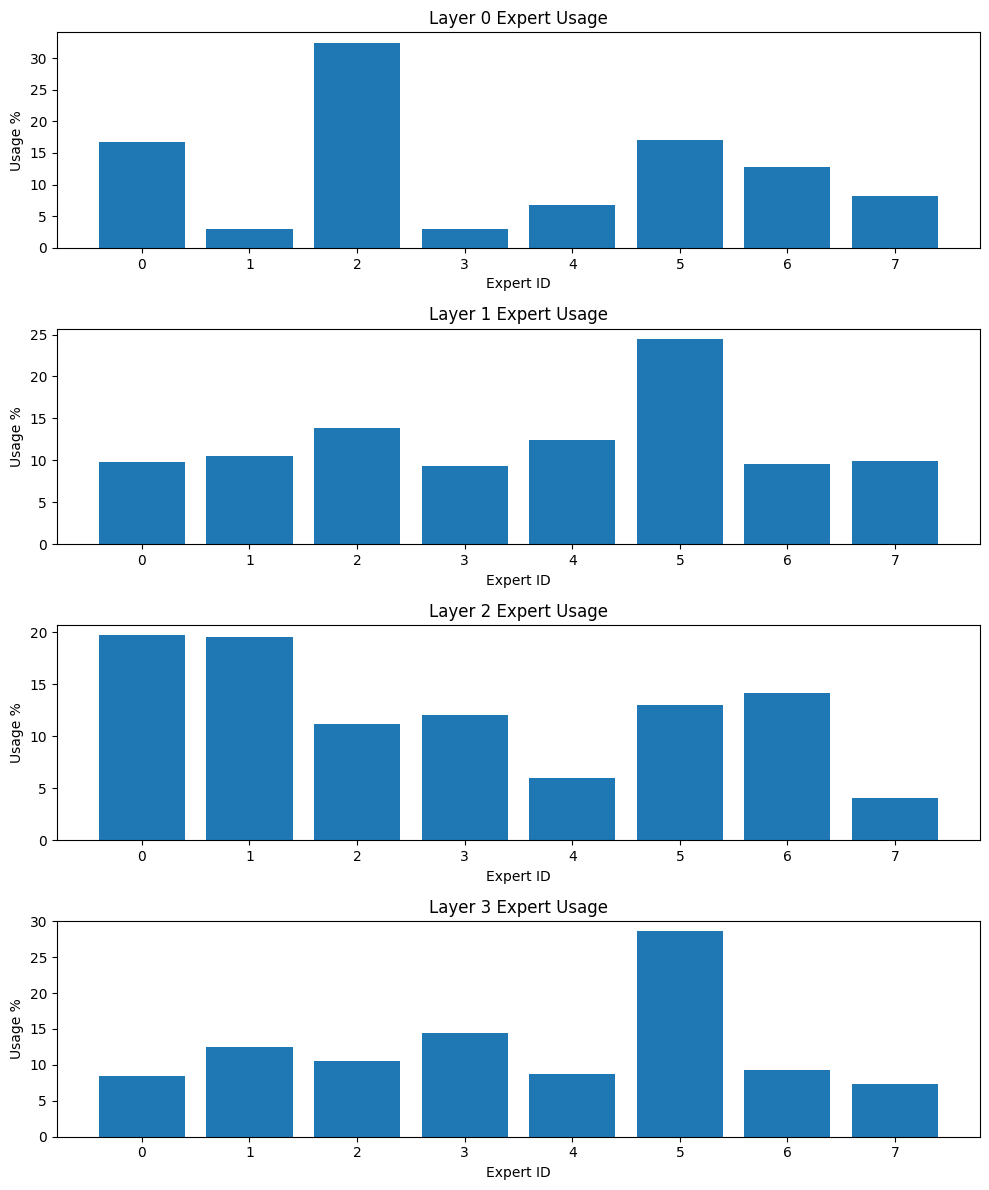


Expert Usage Summary:
Layer 0: E0: 16.7%  E1: 3.0%  E2: 32.4%  E3: 3.1%  E4: 6.8%  E5: 17.0%  E6: 12.8%  E7: 8.2%  
Layer 1: E0: 9.8%  E1: 10.6%  E2: 13.9%  E3: 9.4%  E4: 12.4%  E5: 24.5%  E6: 9.6%  E7: 9.9%  
Layer 2: E0: 19.7%  E1: 19.6%  E2: 11.2%  E3: 12.1%  E4: 6.0%  E5: 13.1%  E6: 14.2%  E7: 4.1%  
Layer 3: E0: 8.5%  E1: 12.5%  E2: 10.6%  E3: 14.4%  E4: 8.7%  E5: 28.6%  E6: 9.3%  E7: 7.3%  

Average active parameters per token: 13,066,031 (50.0% of total)


In [38]:
prompt = torch.tensor(enc.encode("love"), dtype=torch.long).unsqueeze(0).to(device)
xgen, expert_counts, active_params = analyze_expert_usage(model, prompt, generation_length=256)
layer_percentages = visualize_expert_usage(expert_counts)
avg_active_params = sum(active_params) / len(active_params)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nAverage active parameters per token: {avg_active_params:,.0f} ({avg_active_params/total_params:.1%} of total)")

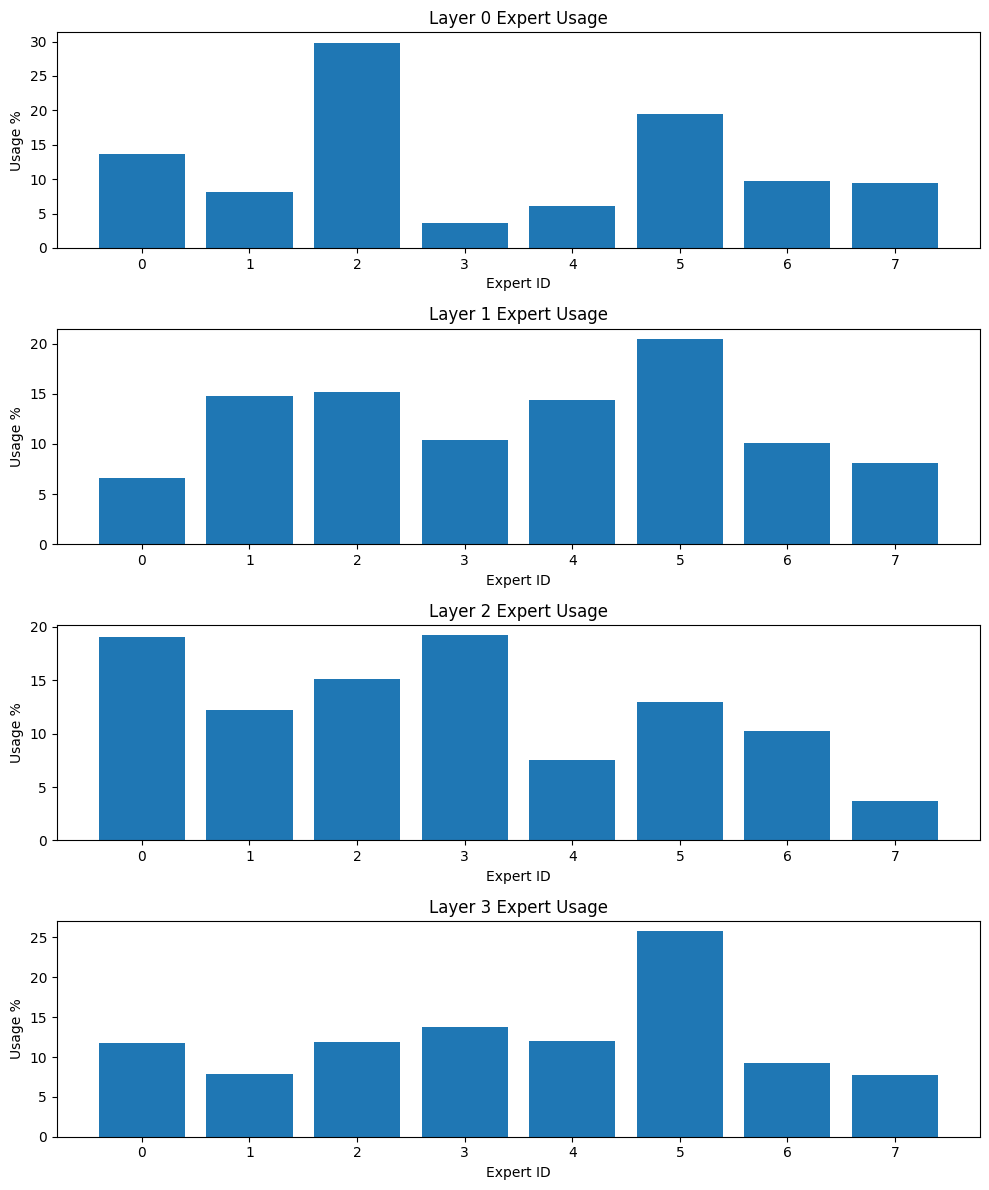


Expert Usage Summary:
Layer 0: E0: 13.6%  E1: 8.1%  E2: 29.8%  E3: 3.6%  E4: 6.1%  E5: 19.5%  E6: 9.8%  E7: 9.5%  
Layer 1: E0: 6.6%  E1: 14.8%  E2: 15.2%  E3: 10.4%  E4: 14.4%  E5: 20.5%  E6: 10.1%  E7: 8.1%  
Layer 2: E0: 19.1%  E1: 12.2%  E2: 15.1%  E3: 19.2%  E4: 7.5%  E5: 13.0%  E6: 10.2%  E7: 3.7%  
Layer 3: E0: 11.8%  E1: 7.8%  E2: 11.8%  E3: 13.8%  E4: 12.0%  E5: 25.8%  E6: 9.3%  E7: 7.7%  

Average active parameters per token: 13M (50.0% of total)


In [43]:
prompt = torch.tensor(enc.encode("motivation"), dtype=torch.long).unsqueeze(0).to(device)
xgen, expert_counts, active_params = analyze_expert_usage(model, prompt, generation_length=256)
layer_percentages = visualize_expert_usage(expert_counts)
avg_active_params = sum(active_params) / len(active_params)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nAverage active parameters per token: {avg_active_params//1e6:,.0f}M ({avg_active_params/total_params:.1%} of total)")

In [ ]:
@torch.inference_mode()
def generate_text(model, prompt_text, max_length=128, num_samples=1):
    prompt = torch.tensor(enc.encode(prompt_text), dtype=torch.long).unsqueeze(0).to(device)
    xgen = prompt.repeat(num_samples, 1)
    generated_texts = [""] * num_samples
    print(f"Prompt: {prompt_text}")
    for i in range(num_samples):
        print(f"\nSample {i+1}: {prompt_text}", end="")
    while xgen.size(1) < max_length:
        logits, _ = model(xgen)
        next_logits = logits[:, -1, :]
        probs = F.softmax(next_logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, 1)
        next_token = torch.gather(topk_indices, -1, ix)
        xgen = torch.cat((xgen, next_token), dim=1)
        for i in range(num_samples):
            token_text = enc.decode([next_token[i].item()])
            generated_texts[i] += token_text
            print(token_text, end="", flush=True)
    print("\n")
    return generated_texts

In [ ]:
samples = generate_text(
    model=model,
    prompt_text="love",
    max_length=512,
    num_samples=1,
)

Prompt: love

Sample 1: love, I was taught from the Bible,  
And he gave me strength to bring, my joy,  
But my soul said ""hey""  
I never meant, no no, no no no no, no no no no!""  
  
Yeah, I went down to the shore,  
Just to turn the page, but I couldn't handle all the other fools,  
I'm a man who walked around like Moses, said, ""Let me go""  
We got drunk on the shore,  
Just to turn the page,  
If my heart said you would stay,  
You'd run for nothing but fear,  
Cause, I found a love I was taught to give,  
But, my heart said ""hello""  
  
No, I'd never do, no way, no no no no  
No, I'd cry for nothing but fear,  
Well, I took some time to look the other lovers that you put in my heart.  
And they took me for nothing but fear,  
But my soul said ""hello"" to the moon, who was made for the sea,  
I had time to give, who I was taught from the Bible,  
He broke my heart and ran through my life, it's all  
  
No, I'd never do, no no no no no, no no no no no no no no no no no no no 

In [ ]:
samples = generate_text(
    model=model,
    prompt_text="love",
    max_length=128,
    num_samples=1,
)

Prompt: love

Sample 1: love, I know you care  
Your heart, I know you care  
Your heart  
Your skin  
  
So darling, darling  
Say I know you care  
Your heart  
Yeah yeah yeah yeah,  
Don't go  
Cause I know you need me too  
I'm your heart  
Yeah yeah yeah

"
"I was looking for  
Out on my own  
I was waiting like a dream  
From my heart and heart  
Was a love  


